In [1]:
import tensorflow as tf
from tensorflow import keras

# FID Calculation

inc_model = keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(150,150,3))


# scale an array of images to a new size
def scale_images(images, new_shape): 
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = np.resize(image, new_shape)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2, verbose=True):
    # preprocessing
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    # resize images
    images1 = scale_images(images1, (150,150,3))
    images2 = scale_images(images2, (150,150,3))

    images1 = keras.applications.inception_v3.preprocess_input(images1)
    images2 = keras.applications.inception_v3.preprocess_input(images2)
    # calculate activations
    act1 = model.predict(images1, verbose=verbose)
    act2 = model.predict(images2, verbose=verbose)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False, dtype=np.csingle)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False, dtype=np.csingle)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = np.sqrt(sigma1*sigma2)
    # check and correct imaginary numbers from sqrt
    covmean = np.real(covmean)
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return np.real(fid)

# define two fake collections of images
# images1 = np.random.randint(0, 255, 10*32*32*3)
# images1 = images1.reshape((10,32,32,3))
# images2 = np.random.randint(0, 255, 10*32*32*3)
# images2 = images2.reshape((10,32,32,3))

# print(calculate_fid(inc_model, images1, images2))
# print(calculate_fid(model, images1, images1))
# print(calculate_fid(model, images2, images2))

2024-07-09 10:38:48.054875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 10:38:48.639258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-09 10:38:49.353363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 10:38:49.353575: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 

%matplotlib inline

In [3]:
class Encoder(nn.Module):
    """The encoder for VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        convs = []
        prev_dim = input_dim
        for conv_dim in conv_dims:
            convs.append(nn.Sequential(
                nn.Conv2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1),
                nn.ReLU()
            ))
            prev_dim = conv_dim
        self.convs = nn.Sequential(*convs)
        
        prev_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
        self.fc = nn.Sequential(
            nn.Linear(prev_dim, fc_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(fc_dim, latent_dim)
        self.fc_log_var = nn.Linear(fc_dim, latent_dim)
                    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
    
class Decoder(nn.Module):
    """The decoder for VAE"""
    
    def __init__(self, latent_dim, image_size, conv_dims, output_dim):
        super().__init__()
        
        fc_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, fc_dim),
            nn.ReLU()
        )
        self.conv_size = image_size // (2 ** len(conv_dims))
        
        de_convs = []
        prev_dim = conv_dims[-1]
        for conv_dim in conv_dims[::-1]:
            de_convs.append(nn.Sequential(
                nn.ConvTranspose2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU()
            ))
            prev_dim = conv_dim
        self.de_convs = nn.Sequential(*de_convs)
        self.pred_layer = nn.Sequential(
            nn.Conv2d(prev_dim, output_dim, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(x.size(0), -1, self.conv_size, self.conv_size)
        x = self.de_convs(x)
        x = self.pred_layer(x)
        return x

In [4]:
class VAE(nn.Module):
    """VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        self.encoder = Encoder(image_size, input_dim, conv_dims, fc_dim, latent_dim)
        self.decoder = Decoder(latent_dim, image_size, conv_dims, input_dim)
        
    def sample_z(self, mu, log_var):
        """sample z by reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sample_z(mu, log_var)
        recon = self.decoder(z)
        return recon, mu, log_var
    
    def compute_loss(self, x, recon, mu, log_var):
        """compute loss of VAE"""
        
        # KL loss
        kl_loss = (0.5*(log_var.exp() + mu ** 2 - 1 - log_var)).sum(1).mean()
        
        # recon loss
        recon_loss = F.binary_cross_entropy(recon, x, reduction="none").sum([1, 2, 3]).mean()
        
        return kl_loss + recon_loss

## Trying vae with Aug, without KL term, with latent_dim=4

In [5]:
class VAE(nn.Module):
    """VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        self.encoder = Encoder(image_size, input_dim, conv_dims, fc_dim, latent_dim)
        self.decoder = Decoder(latent_dim, image_size, conv_dims, input_dim)
        
    def sample_z(self, mu, log_var):
        """sample z by reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sample_z(mu, log_var)
        recon = self.decoder(z)
        return recon, mu, log_var
    
    def compute_loss(self, x, recon, mu, log_var):
        """compute loss of VAE"""
        
        # KL loss
        kl_loss = (0.5*(log_var.exp() + mu ** 2 - 1 - log_var)).sum(1).mean()
        
        # recon loss
        x = x.clip(min=0., max=1.)
        recon_loss = F.binary_cross_entropy(recon, x, reduction="none").sum([1, 2, 3]).mean()
        
        return recon_loss

In [8]:
# Augmentations : 
# Random rotations, translation
# some noise

from torchvision.transforms import v2

image_size = 28
conv_dims = [64, 128]
fc_dim = 1024
latent_dim = 10 # trying with 10

batch_size = 32 # 1024
epochs = 100

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(f'{device=}')

transform=v2.Compose([
    transforms.ToTensor(),
    v2.RandomAffine(degrees=20, translate=(0.2,0.2)),
    v2.RandomZoomOut(side_range=(1.,2.)),
    transforms.Resize(image_size)
])

dataset1 = datasets.MNIST('data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('data_test', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).to(device)
# model = torch.compile(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

device='cuda:1'
params 6809493


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, loss 87.72256469726562
Epoch 5, loss 78.11925506591797
Epoch 10, loss 94.5744400024414
Epoch 15, loss 75.65777587890625
Epoch 20, loss 75.27300262451172
Epoch 25, loss 82.83364868164062
Epoch 30, loss 82.185302734375
Epoch 35, loss 91.09313201904297
Epoch 40, loss 70.32855224609375
Epoch 45, loss 72.9865951538086
Epoch 50, loss 73.42646789550781
Epoch 55, loss 76.49921417236328
Epoch 60, loss 67.99586486816406
Epoch 65, loss 84.59500122070312
Epoch 70, loss 71.905029296875
Epoch 75, loss 75.29462432861328
Epoch 80, loss 72.7098388671875
Epoch 85, loss 76.62571716308594
Epoch 90, loss 82.53567504882812
Epoch 95, loss 71.21392822265625


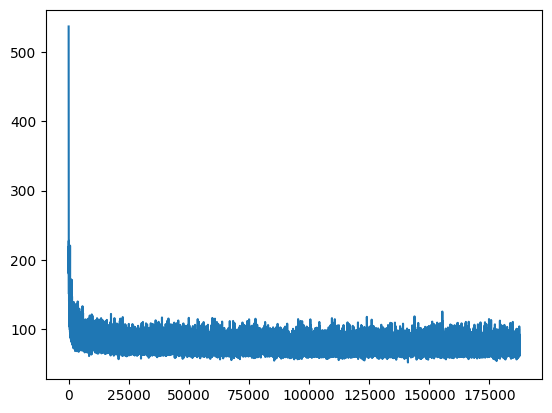

In [9]:
def add_sp_noise(image, p1=0.03, p2=-1) :
    # add pepper with prob p1
    # add salt with prov p2
    if p2==-1 : p2=p1
    image[torch.rand_like(image)<p1] = 0.
    image[torch.rand_like(image)<p2] = 1.
    return image

def mask(image, width=4) :
    x = torch.randint(0, image.shape[-1]-width+1, size=(1,))
    y = torch.randint(0, image.shape[-1]-width+1, size=(1,))
    image[x:x+width, y:y+width] = 0.
    return image


lam = 0.01
losslog = []
p1 = 0.3
p2 = 0.3
for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) #; images.requires_grad_()
        recon, mu, log_var = model(images)
        if torch.randn(1)<=p1 : recon, mu, log_var = model(add_sp_noise(images.clone())) # denoising
        elif torch.randn(1)<=p2 : recon, mu, log_var = model(mask(images.clone())) # masking
        else : recon, mu, log_var = model(images)
        loss = model.compute_loss(images, recon, mu, log_var)
        # # adding contractive loss
        # loss += lam*sum([torch.autograd.grad(rec, images, retain_graph=True)[0].norm()**2 for rec in recon.reshape(-1)])**0.5

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%5==0 : 
        tqdm.write(f'Epoch {epoch}, loss {loss.item()}')


plt.plot(losslog)

In [10]:
torch.save(model, 'models/mnist_10d_withAug.pt')

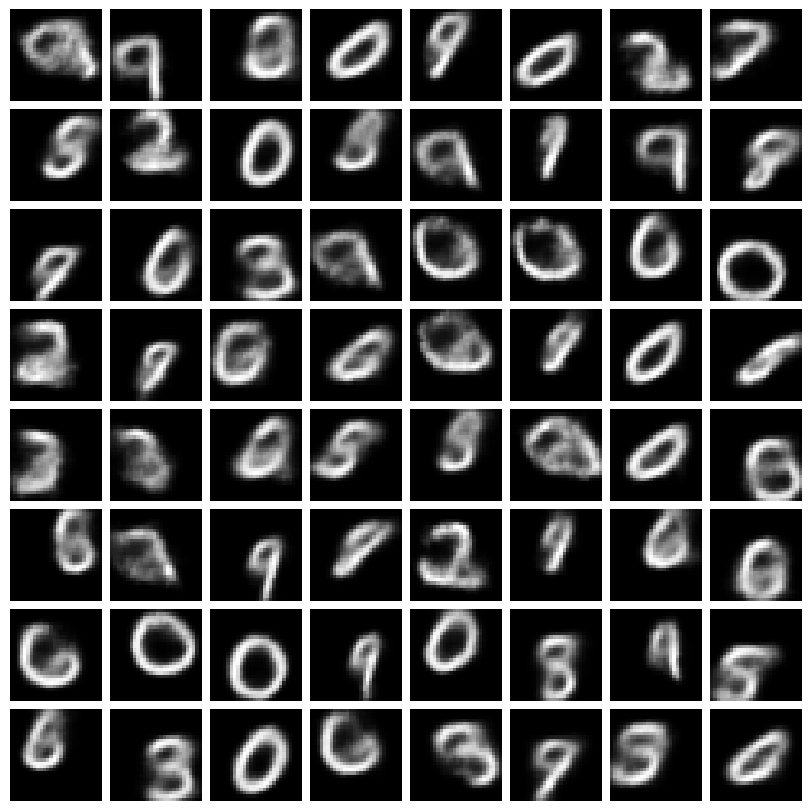

In [8]:
# generating by sampling from N(0, I)
## generate new images by VAE, sampling from N(0,I)
sample_zs = torch.randn(64, latent_dim).to(device)
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [11]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=None)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = torch.randn(1000, latent_dim)
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda(1))
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step
FID (1000 images) : 102.91443634033203


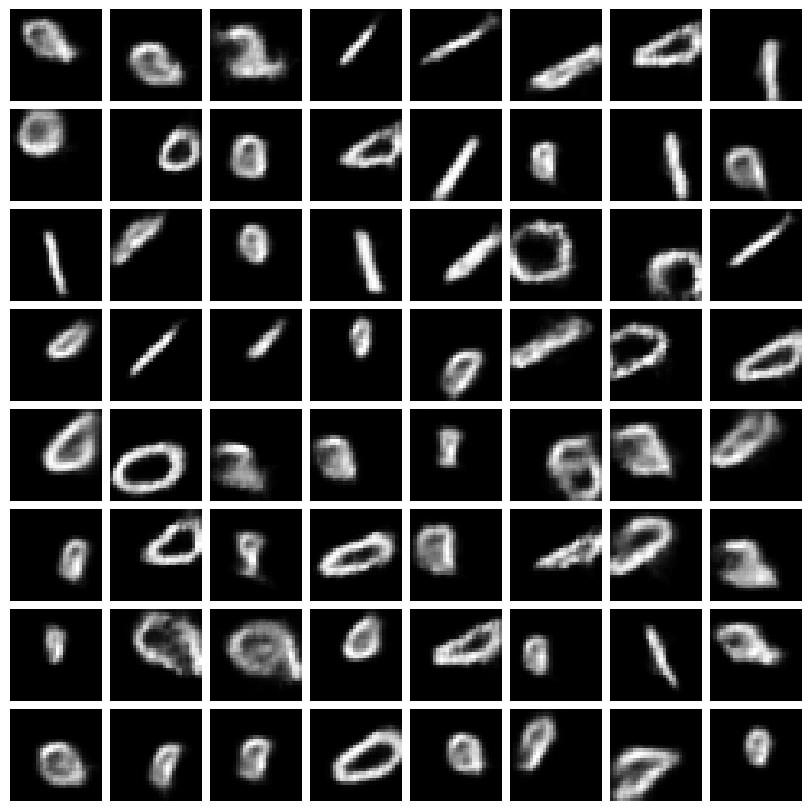

In [9]:
# sampling from N(mu, sigma)
import scipy

with torch.no_grad() : pivots = model.encoder(next(iter(train_loader))[0].cuda(1))[0].cpu()
mu = pivots.mean(dim=0, keepdims=True)
sigma = scipy.linalg.sqrtm(pivots.transpose(0,1).cov()).real
sample_zs = (mu + torch.randn(64, latent_dim)@sigma).to('cuda:1')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [11]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = (mu + torch.randn(1000, latent_dim)@sigma).to('cuda:1')
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda(1))
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step
FID (1000 images) : 77.55390930175781


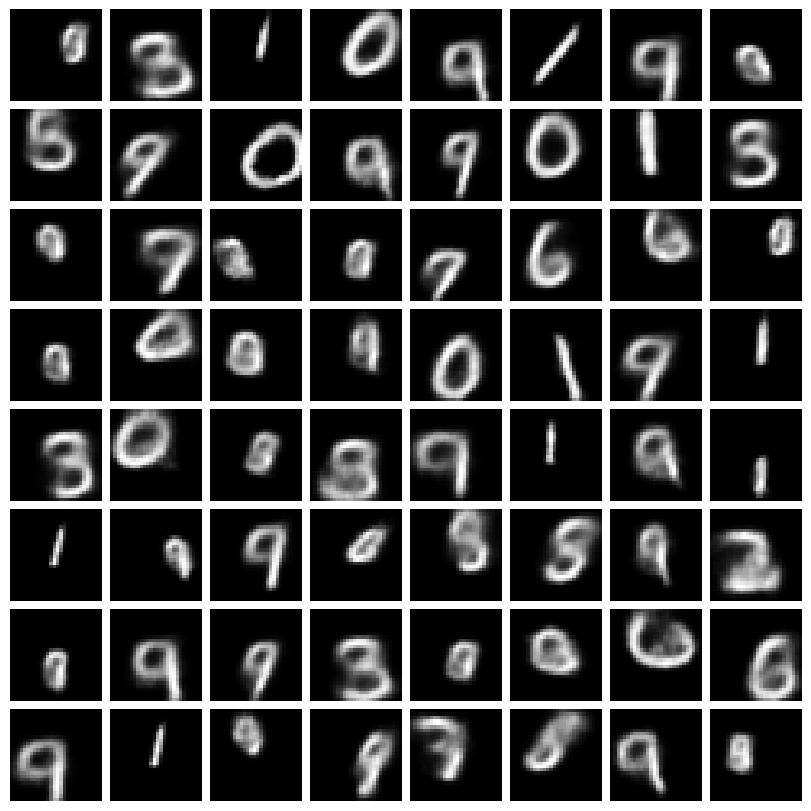

In [12]:
loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
with torch.no_grad() :
    pivots = model.encoder(next(iter(loader))[0].cuda(1))[0].cpu()
    recons = model.decoder(pivots.cuda(1)).cpu()
recons = np.array(recons[:64] * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(recons[n_row, n_col], cmap="gray")
        f_ax.axis("off")